In [4]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=81b1d5ed415e8ab03609c6a766c92584090b59a93444d5af022c891a14307369
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [5]:
import torch

import idx2numpy

import torch.nn as nn

import torch.optim as optim

from torchvision import datasets, transforms

from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

import time

In [6]:
# Check GPU availability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)

cuda


In [8]:
import os

# Check if the dataset directory exists
dataset_dir = '/kaggle/input/mnist-dataset/'
print(os.listdir(dataset_dir))

['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


In [9]:
import idx2numpy
import os

# Check if the dataset directory exists
dataset_dir = '/kaggle/input/mnist-dataset/'
print(os.listdir(dataset_dir))

# Update paths with the correct filenames
train_images_path = os.path.join(dataset_dir, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels_path = os.path.join(dataset_dir, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_path = os.path.join(dataset_dir, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_path = os.path.join(dataset_dir, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Load data into NumPy arrays
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

# Check the shapes of loaded data
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [10]:
# customize my data for pytorch

class mnist_data(Dataset):

  def __init__(self, images, labels, transform):

    self.images = images

    self.labels = labels

    self.transform = transform



  def __len__ (self):

    return len(self.labels)



  def __getitem__(self, index) :

    image = self.images[index]

    label = self.labels[index]

    image = self.transform(image)

    return image, label

In [11]:
# Define transformations

transform = transforms.Compose([

    transforms.ToPILImage(),

    transforms.Resize((224, 224)),

    transforms.ToTensor(),

    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]

])

In [12]:
train_dataset = mnist_data(train_images, train_labels, transform)

test_dataset = mnist_data(test_images, test_labels, transform)





# create dataloader for batching

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 213MB/s]  


In [15]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [17]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [18]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [19]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [20]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [21]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

In [22]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [24]:
for name, param in model.named_parameters():

    print(f"{name}: {param.size()}")

features.0.weight: torch.Size([64, 1, 11, 11])
features.0.bias: torch.Size([64])
features.3.weight: torch.Size([192, 64, 5, 5])
features.3.bias: torch.Size([192])
features.6.weight: torch.Size([384, 192, 3, 3])
features.6.bias: torch.Size([384])
features.8.weight: torch.Size([256, 384, 3, 3])
features.8.bias: torch.Size([256])
features.10.weight: torch.Size([256, 256, 3, 3])
features.10.bias: torch.Size([256])
classifier.1.weight: torch.Size([4096, 9216])
classifier.1.bias: torch.Size([4096])
classifier.4.weight: torch.Size([4096, 4096])
classifier.4.bias: torch.Size([4096])
classifier.6.weight: torch.Size([10, 4096])
classifier.6.bias: torch.Size([10])


In [26]:
# Entraînement du modèle

num_epochs = 10

start_time = time.time()

In [27]:
for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)



        # Forward pass

        outputs = model(images)

        loss = criterion(outputs, labels)



        # Backward pass

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()



        running_loss += loss.item()



    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")



training_time = time.time() - start_time

print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/10, Loss: 0.3625
Epoch 2/10, Loss: 0.0457
Epoch 3/10, Loss: 0.0317
Epoch 4/10, Loss: 0.0254
Epoch 5/10, Loss: 0.0197
Epoch 6/10, Loss: 0.0177
Epoch 7/10, Loss: 0.0138
Epoch 8/10, Loss: 0.0115
Epoch 9/10, Loss: 0.0101
Epoch 10/10, Loss: 0.0083
Training Time: 742.85 seconds


In [28]:
# Évaluation

model.eval()

all_preds = []

all_labels = []



with torch.no_grad():

    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())



# Calcul des métriques

accuracy = accuracy_score(all_labels, all_preds)

f1 = f1_score(all_labels, all_preds, average="weighted")



print(f"Accuracy: {accuracy:.4f}")

print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9960
F1 Score: 0.9960


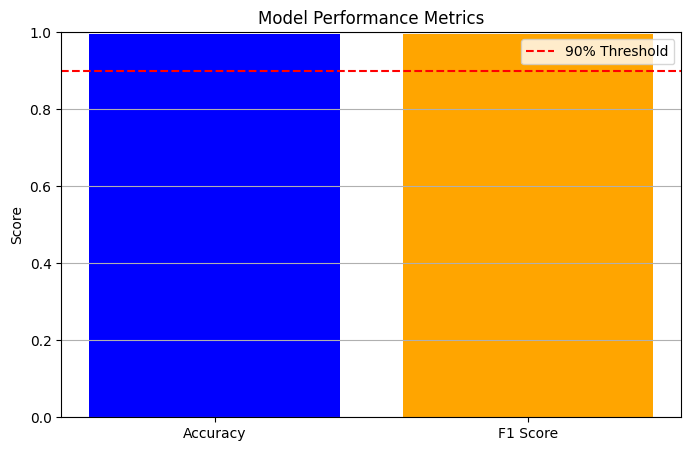

In [29]:
# Data for plotting

metrics = ['Accuracy', 'F1 Score']

values = [accuracy, f1]



# Create a bar chart

plt.figure(figsize=(8, 5))

plt.bar(metrics, values, color=['blue', 'orange'])

plt.ylim(0, 1)  # Set y-axis limits from 0 to 1

plt.title('Model Performance Metrics')

plt.ylabel('Score')

plt.axhline(y=0.90, color='red', linestyle='--', label='90% Threshold')  # Optional threshold line

plt.legend()

plt.grid(axis='y')



# Show the plot

plt.show()